# Лабораторная работа 1

In [ ]:
# !pip install -r requierments.txt

In [2]:

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score, get_scorer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import clone
import numpy as np
import matplotlib.pyplot as plt
import optuna
from catboost import CatBoostRegressor
import time

## Загрузка данных


In [3]:

data = fetch_california_housing(as_frame=True)
df = data.frame.copy()
X = data.data.copy()
y = data.target.copy()

print(df.shape)
df.head()

(20640, 9)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


## Выборка

In [4]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((16512, 8), (4128, 8), (16512,), (4128,))

## Модели и метрики


In [5]:
def metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {"MAE": mae, "RMSE": rmse, "R2": r2}

In [6]:
pipeline_lr = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LinearRegression())
])

pipeline_lr.fit(X_train, y_train)
pred_lr = pipeline_lr.predict(X_test)
metrics_lr = metrics(y_test, pred_lr)

rf = RandomForestRegressor(
    n_estimators=200, random_state=42, n_jobs=-1
)

rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)
metrics_rf = metrics(y_test, pred_rf)

print("LinearRegression:", metrics_lr)
print("RandomForestRegressor:", metrics_rf)

LinearRegression: {'MAE': 0.5332001304956565, 'RMSE': 0.7455813830127764, 'R2': 0.5757877060324508}
RandomForestRegressor: {'MAE': 0.3268118504360468, 'RMSE': 0.5039602414072009, 'R2': 0.8061857564039718}


## Графики остатков

In [7]:
def pred_vs_actual_plot(y_true, y_pred, title):
    plt.figure()
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(title)
    plt.show()

def residuals_vs_pred_plot(y_true, y_pred, title):
    plt.figure()
    plt.scatter(y_pred, y_true - y_pred, alpha=0.5)
    plt.xlabel("Predicted")
    plt.ylabel("Residuals")
    plt.title(title)
    plt.show()

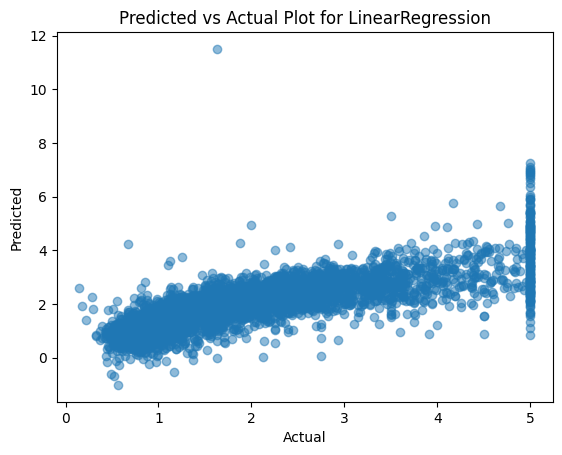

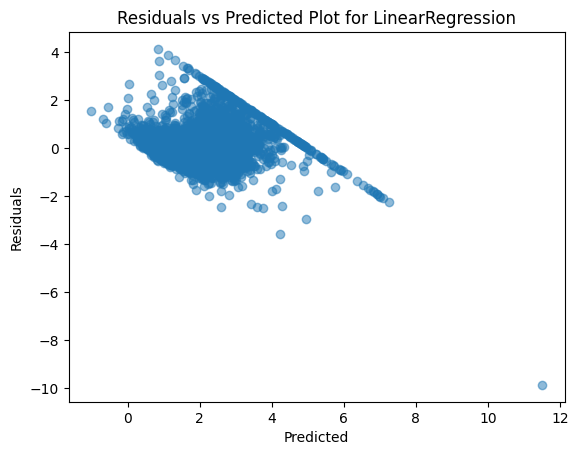

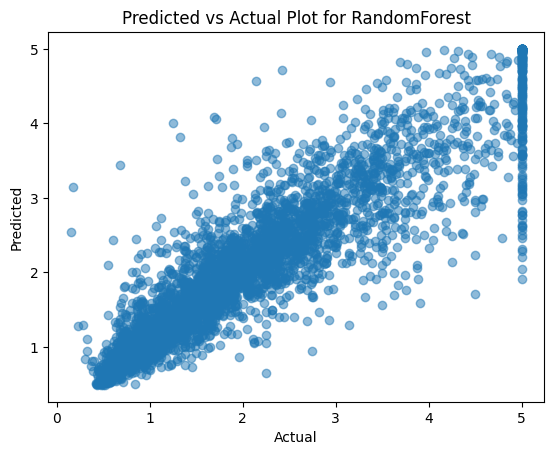

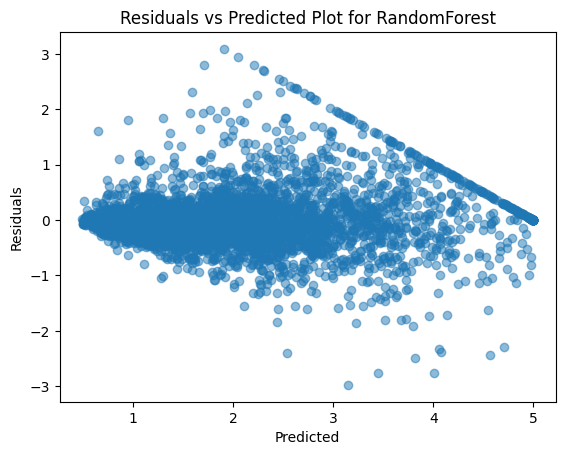

In [8]:
pred_vs_actual_plot(y_test.values, pred_lr,
                    title="Predicted vs Actual Plot for LinearRegression")
residuals_vs_pred_plot(y_test.values, pred_lr,
                       title="Residuals vs Predicted Plot for LinearRegression")

pred_vs_actual_plot(y_test.values, pred_rf,
                    title="Predicted vs Actual Plot for RandomForest")
residuals_vs_pred_plot(y_test.values, pred_rf,
                       title="Residuals vs Predicted Plot for RandomForest")

## Подбор гиперпараметров

In [9]:
def rmse(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    return float(np.sqrt(np.mean((y_true - y_pred) ** 2)))

In [ ]:
def objective_rf(trial):
    n_estimators = trial.suggest_int("n_estimators", 100, 600, step=50)
    max_depth = trial.suggest_int("max_depth", 3, 30)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)

    base_model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42,
        n_jobs=-1
    )

    crossvalidation = KFold(n_splits=3, shuffle=True, random_state=42)
    fold_scores = []

    indexes = np.arange(len(X_train))

    for fold_id, (train, valid) in enumerate(crossvalidation.split(indexes)):
        model = clone(base_model)

        X_tr = X_train.iloc[train]
        y_tr = y_train.iloc[train]
        X_vl = X_train.iloc[valid]
        y_vl = y_train.iloc[valid]

        try:
            model.fit(X_tr, y_tr)
            y_pr = model.predict(X_vl)
            score_rmse = rmse(y_vl, y_pr)
        except Exception as e:
            print(f"trial={trial.number} | fold {fold_id} error: {e}")
            score_rmse = float("inf")

        fold_scores.append(score_rmse)

        print(f"trial={trial.number} | fold {fold_id}: RMSE={score_rmse}")

    mean_rmse = float(np.mean(fold_scores)) if len(
        fold_scores) else float("inf")
    print(f"trial={trial.number} | mean RMSE={mean_rmse}")
    return -mean_rmse

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective_rf, n_trials=30)

print("Best params:", study.best_params)
print("Best (neg-RMSE):", study.best_value)

## Фабрика

In [10]:
def gen_objective(estimator_class, grid, X_train, y_train,
                  *, cv=3, scorer="neg_root_mean_squared_error",
                  fit_params=None, random_state=42, n_jobs=-1, verbose=True):
    fit_params = {} if fit_params is None else dict(fit_params)

    if not isinstance(grid, dict) or not grid:
        raise ValueError(
            "grid must be not empty dict ({param: (type, ...)})")

    def suggest_param(trial, name, spec):
        if not isinstance(spec, (tuple, list)) or not spec:
            raise ValueError(f"Error spec {name}: {spec}")
        ptype = spec[0]
        if ptype == "int":
            low, high = spec[1], spec[2]
            step = spec[3] if len(spec) > 3 else 1
            return trial.suggest_int(name, int(low), int(high), step=int(step))
        elif ptype == "float":
            low, high = float(spec[1]), float(spec[2])
            log = bool(spec[3]) if len(spec) > 3 else False
            return trial.suggest_float(name, low, high, log=log)
        elif ptype == "categorical":
            choices = list(spec[1])
            return trial.suggest_categorical(name, choices)
        else:
            raise ValueError(
                f"Error space type {ptype} for {name}")

    if isinstance(scorer, str):
        try:
            scorer_obj = get_scorer(scorer)
        except Exception:
            if verbose:
                print(
                    f"Error scorer={scorer} | used=neg_root_mean_squared_error")
            scorer_obj = get_scorer("neg_root_mean_squared_error")
    else:
        scorer_obj = scorer

    idx = np.arange(len(X_train))

    def objective(trial):
        t0 = time.time()

        params = {name: suggest_param(trial, name, spec)
                  for name, spec in grid.items()}

        try:
            probe = estimator_class()
            base_params = getattr(probe, "get_params", lambda: {})()
        except Exception:
            base_params = {}

        model_kwargs = {}
        if "random_state" in base_params:
            model_kwargs["random_state"] = random_state
        if "n_jobs" in base_params:
            model_kwargs["n_jobs"] = n_jobs

        model = estimator_class(**model_kwargs, **params)

        kf = KFold(n_splits=cv, shuffle=True, random_state=42)
        fold_scores = []

        for fold_id, (tr_idx, vl_idx) in enumerate(kf.split(idx), start=1):
            m = clone(model)
            X_tr = X_train.iloc[tr_idx]
            y_tr = y_train.iloc[tr_idx]
            X_vl = X_train.iloc[vl_idx]
            y_vl = y_train.iloc[vl_idx]

            try:
                m.fit(X_tr, y_tr, **fit_params)
                s = scorer_obj(m, X_vl, y_vl)
                s = float(s)
                if not np.isfinite(s):
                    if verbose:
                        print(
                            f"trial={trial.number} | fold {fold_id}: score is not finite, set to -1e12")
                    s = -1e12
            except Exception as e:
                if verbose:
                    print(
                        f"trial={trial.number} | fold {fold_id} error: {e}")
                s = -1e12

            fold_scores.append(s)

            if verbose:
                print(f"trial {trial.number} | fold {fold_id} score={s}")

        mean_score = float(np.mean(fold_scores)) if fold_scores else -1e12
        if not np.isfinite(mean_score):
            mean_score = -1e12

        if verbose:
            dt = time.time() - t0
            print(
                f"trial={trial.number} | mean_score={mean_score} | time={dt} | params={params}")

        return mean_score

    return objective

[I 2025-12-02 13:35:30,116] A new study created in memory with name: no-name-9b71077e-157f-4dcd-ac36-26a209e05ba3


trial 0 | fold 1 score=-0.5468937824285088
trial 0 | fold 2 score=-0.5313224599333956


[I 2025-12-02 13:35:34,046] Trial 0 finished with value: -0.5425916806925812 and parameters: {'depth': 5, 'learning_rate': 0.009916036356176243, 'l2_leaf_reg': 0.031535995374767666, 'iterations': 700}. Best is trial 0 with value: -0.5425916806925812.


trial 0 | fold 3 score=-0.5495587997158393
trial=0 | mean_score=-0.5425916806925812 | time=3.9273276329040527 | params={'depth': 5, 'learning_rate': 0.009916036356176243, 'l2_leaf_reg': 0.031535995374767666, 'iterations': 700}
trial 1 | fold 1 score=-0.6192893492739611
trial 1 | fold 2 score=-0.6041694231159045


[I 2025-12-02 13:35:36,742] Trial 1 finished with value: -0.6128946249318172 and parameters: {'depth': 6, 'learning_rate': 0.006458339785819846, 'l2_leaf_reg': 0.030019911470742882, 'iterations': 400}. Best is trial 0 with value: -0.5425916806925812.


trial 1 | fold 3 score=-0.615225102405586
trial=1 | mean_score=-0.6128946249318172 | time=2.695408821105957 | params={'depth': 6, 'learning_rate': 0.006458339785819846, 'l2_leaf_reg': 0.030019911470742882, 'iterations': 400}
trial 2 | fold 1 score=-0.6378223043779664
trial 2 | fold 2 score=-0.6229168054303955


[I 2025-12-02 13:35:57,717] Trial 2 finished with value: -0.6310181404204688 and parameters: {'depth': 9, 'learning_rate': 0.0014297559717003448, 'l2_leaf_reg': 0.37635852936467457, 'iterations': 1200}. Best is trial 0 with value: -0.5425916806925812.


trial 2 | fold 3 score=-0.6323153114530444
trial=2 | mean_score=-0.6310181404204688 | time=20.971632480621338 | params={'depth': 9, 'learning_rate': 0.0014297559717003448, 'l2_leaf_reg': 0.37635852936467457, 'iterations': 1200}
trial 3 | fold 1 score=-0.8239283802454133
trial 3 | fold 2 score=-0.806932539536445


[I 2025-12-02 13:36:52,032] Trial 3 finished with value: -0.8129774056364049 and parameters: {'depth': 10, 'learning_rate': 0.0011476214078737638, 'l2_leaf_reg': 0.02825879223223226, 'iterations': 600}. Best is trial 0 with value: -0.5425916806925812.


trial 3 | fold 3 score=-0.8080712971273561
trial=3 | mean_score=-0.8129774056364049 | time=54.31184267997742 | params={'depth': 10, 'learning_rate': 0.0011476214078737638, 'l2_leaf_reg': 0.02825879223223226, 'iterations': 600}
trial 4 | fold 1 score=-0.4885584243789796
trial 4 | fold 2 score=-0.477895405540481


[I 2025-12-02 13:36:53,376] Trial 4 finished with value: -0.48698626326901956 and parameters: {'depth': 6, 'learning_rate': 0.08075276200836146, 'l2_leaf_reg': 2.1728888496864025, 'iterations': 200}. Best is trial 4 with value: -0.48698626326901956.


trial 4 | fold 3 score=-0.4945049598875979
trial=4 | mean_score=-0.48698626326901956 | time=1.3413617610931396 | params={'depth': 6, 'learning_rate': 0.08075276200836146, 'l2_leaf_reg': 2.1728888496864025, 'iterations': 200}
trial 5 | fold 1 score=-0.4638536423078073
trial 5 | fold 2 score=-0.44989458987828157


[I 2025-12-02 13:37:05,744] Trial 5 finished with value: -0.4600377049075532 and parameters: {'depth': 8, 'learning_rate': 0.02225889342958565, 'l2_leaf_reg': 0.8617435497647173, 'iterations': 1100}. Best is trial 5 with value: -0.4600377049075532.


trial 5 | fold 3 score=-0.46636488253657066
trial=5 | mean_score=-0.4600377049075532 | time=12.36548638343811 | params={'depth': 8, 'learning_rate': 0.02225889342958565, 'l2_leaf_reg': 0.8617435497647173, 'iterations': 1100}
trial 6 | fold 1 score=-0.46103313488038217
trial 6 | fold 2 score=-0.4492445499987893


[I 2025-12-02 13:37:18,930] Trial 6 finished with value: -0.4583031304271176 and parameters: {'depth': 8, 'learning_rate': 0.025993161340154967, 'l2_leaf_reg': 5.043479823129901, 'iterations': 1200}. Best is trial 6 with value: -0.4583031304271176.


trial 6 | fold 3 score=-0.46463170640218143
trial=6 | mean_score=-0.4583031304271176 | time=13.181397914886475 | params={'depth': 8, 'learning_rate': 0.025993161340154967, 'l2_leaf_reg': 5.043479823129901, 'iterations': 1200}
trial 7 | fold 1 score=-0.4585513000717552
trial 7 | fold 2 score=-0.4336222968393954


[I 2025-12-02 13:37:41,029] Trial 7 finished with value: -0.44974327021153265 and parameters: {'depth': 9, 'learning_rate': 0.09838549688108379, 'l2_leaf_reg': 0.032953500654236086, 'iterations': 1300}. Best is trial 7 with value: -0.44974327021153265.


trial 7 | fold 3 score=-0.4570562137234473
trial=7 | mean_score=-0.44974327021153265 | time=22.096441507339478 | params={'depth': 9, 'learning_rate': 0.09838549688108379, 'l2_leaf_reg': 0.032953500654236086, 'iterations': 1300}
trial 8 | fold 1 score=-0.5344982091985637
trial 8 | fold 2 score=-0.5196481254202915


[I 2025-12-02 13:37:47,429] Trial 8 finished with value: -0.5304532029798916 and parameters: {'depth': 5, 'learning_rate': 0.007186821159200077, 'l2_leaf_reg': 0.514293107106775, 'iterations': 1200}. Best is trial 7 with value: -0.44974327021153265.


trial 8 | fold 3 score=-0.5372132743208197
trial=8 | mean_score=-0.5304532029798916 | time=6.398721933364868 | params={'depth': 5, 'learning_rate': 0.007186821159200077, 'l2_leaf_reg': 0.514293107106775, 'iterations': 1200}
trial 9 | fold 1 score=-0.5627411363729163
trial 9 | fold 2 score=-0.5516905068848963


[I 2025-12-02 13:37:50,882] Trial 9 finished with value: -0.55964213619259 and parameters: {'depth': 8, 'learning_rate': 0.010766911568087584, 'l2_leaf_reg': 0.042618920768203714, 'iterations': 300}. Best is trial 7 with value: -0.44974327021153265.


trial 9 | fold 3 score=-0.5644947653199572
trial=9 | mean_score=-0.55964213619259 | time=3.451815128326416 | params={'depth': 8, 'learning_rate': 0.010766911568087584, 'l2_leaf_reg': 0.042618920768203714, 'iterations': 300}
trial 10 | fold 1 score=-0.47483511101337406
trial 10 | fold 2 score=-0.46182558656233996


[I 2025-12-02 13:40:04,962] Trial 10 finished with value: -0.47185848166695704 and parameters: {'depth': 10, 'learning_rate': 0.23832076870569222, 'l2_leaf_reg': 0.12443878042348935, 'iterations': 1500}. Best is trial 7 with value: -0.44974327021153265.


trial 10 | fold 3 score=-0.47891474742515705
trial=10 | mean_score=-0.47185848166695704 | time=134.0758957862854 | params={'depth': 10, 'learning_rate': 0.23832076870569222, 'l2_leaf_reg': 0.12443878042348935, 'iterations': 1500}
trial 11 | fold 1 score=-0.44864293631576485
trial 11 | fold 2 score=-0.43546214490225926


[I 2025-12-02 13:40:21,259] Trial 11 finished with value: -0.4451517504053455 and parameters: {'depth': 8, 'learning_rate': 0.056580598657717716, 'l2_leaf_reg': 5.3558008152179575, 'iterations': 1500}. Best is trial 11 with value: -0.4451517504053455.


trial 11 | fold 3 score=-0.4513501699980125
trial=11 | mean_score=-0.4451517504053455 | time=16.292717933654785 | params={'depth': 8, 'learning_rate': 0.056580598657717716, 'l2_leaf_reg': 5.3558008152179575, 'iterations': 1500}
trial 12 | fold 1 score=-0.4481225642954154
trial 12 | fold 2 score=-0.43436972953505815


[I 2025-12-02 13:40:33,539] Trial 12 finished with value: -0.4448709681684815 and parameters: {'depth': 7, 'learning_rate': 0.07744813207502377, 'l2_leaf_reg': 9.380100353874912, 'iterations': 1500}. Best is trial 12 with value: -0.4448709681684815.


trial 12 | fold 3 score=-0.4521206106749709
trial=12 | mean_score=-0.4448709681684815 | time=12.279044151306152 | params={'depth': 7, 'learning_rate': 0.07744813207502377, 'l2_leaf_reg': 9.380100353874912, 'iterations': 1500}
trial 13 | fold 1 score=-0.4512217408017711
trial 13 | fold 2 score=-0.4377348889230179


[I 2025-12-02 13:40:45,582] Trial 13 finished with value: -0.4476109593285982 and parameters: {'depth': 7, 'learning_rate': 0.057530902909947536, 'l2_leaf_reg': 8.110079260573992, 'iterations': 1500}. Best is trial 12 with value: -0.4448709681684815.


trial 13 | fold 3 score=-0.4538762482610056
trial=13 | mean_score=-0.4476109593285982 | time=12.040847778320312 | params={'depth': 7, 'learning_rate': 0.057530902909947536, 'l2_leaf_reg': 8.110079260573992, 'iterations': 1500}
trial 14 | fold 1 score=-0.45658414715693524
trial 14 | fold 2 score=-0.44301584786734594


[I 2025-12-02 13:40:53,644] Trial 14 finished with value: -0.4521378303650509 and parameters: {'depth': 7, 'learning_rate': 0.21892718825394802, 'l2_leaf_reg': 2.26061199061811, 'iterations': 900}. Best is trial 12 with value: -0.4448709681684815.


trial 14 | fold 3 score=-0.4568134960708714
trial=14 | mean_score=-0.4521378303650509 | time=8.059814453125 | params={'depth': 7, 'learning_rate': 0.21892718825394802, 'l2_leaf_reg': 2.26061199061811, 'iterations': 900}
trial 15 | fold 1 score=-0.4691442557570227
trial 15 | fold 2 score=-0.45774192080023096


[I 2025-12-02 13:41:00,379] Trial 15 finished with value: -0.46661531014568 and parameters: {'depth': 4, 'learning_rate': 0.03927399223128956, 'l2_leaf_reg': 2.6968380865810335, 'iterations': 1500}. Best is trial 12 with value: -0.4448709681684815.


trial 15 | fold 3 score=-0.4729597538797863
trial=15 | mean_score=-0.46661531014568 | time=6.733173370361328 | params={'depth': 4, 'learning_rate': 0.03927399223128956, 'l2_leaf_reg': 2.6968380865810335, 'iterations': 1500}
trial 16 | fold 1 score=-0.4540768956242974
trial 16 | fold 2 score=-0.4400568192307118


[I 2025-12-02 13:41:06,915] Trial 16 finished with value: -0.4494033820638111 and parameters: {'depth': 6, 'learning_rate': 0.12153026175062558, 'l2_leaf_reg': 9.978113866663438, 'iterations': 1000}. Best is trial 12 with value: -0.4448709681684815.


trial 16 | fold 3 score=-0.45407643133642406
trial=16 | mean_score=-0.4494033820638111 | time=6.5345964431762695 | params={'depth': 6, 'learning_rate': 0.12153026175062558, 'l2_leaf_reg': 9.978113866663438, 'iterations': 1000}
trial 17 | fold 1 score=-0.45008888810372244
trial 17 | fold 2 score=-0.43604093924404197


[I 2025-12-02 13:41:31,939] Trial 17 finished with value: -0.4465199007136445 and parameters: {'depth': 9, 'learning_rate': 0.043534283694135804, 'l2_leaf_reg': 1.196401715635549, 'iterations': 1400}. Best is trial 12 with value: -0.4448709681684815.


trial 17 | fold 3 score=-0.4534298747931691
trial=17 | mean_score=-0.4465199007136445 | time=25.01785635948181 | params={'depth': 9, 'learning_rate': 0.043534283694135804, 'l2_leaf_reg': 1.196401715635549, 'iterations': 1400}
trial 18 | fold 1 score=-0.46226538559876784
trial 18 | fold 2 score=-0.4419929431368485


[I 2025-12-02 13:41:38,665] Trial 18 finished with value: -0.453228500789222 and parameters: {'depth': 7, 'learning_rate': 0.16344094404538922, 'l2_leaf_reg': 0.1314229905006061, 'iterations': 800}. Best is trial 12 with value: -0.4448709681684815.


trial 18 | fold 3 score=-0.4554271736320497
trial=18 | mean_score=-0.453228500789222 | time=6.724665880203247 | params={'depth': 7, 'learning_rate': 0.16344094404538922, 'l2_leaf_reg': 0.1314229905006061, 'iterations': 800}
trial 19 | fold 1 score=-0.5486024910793945
trial 19 | fold 2 score=-0.5358586179879272


[I 2025-12-02 13:41:53,848] Trial 19 finished with value: -0.5453860769193263 and parameters: {'depth': 8, 'learning_rate': 0.003132334303638498, 'l2_leaf_reg': 4.488278538443917, 'iterations': 1300}. Best is trial 12 with value: -0.4448709681684815.


trial 19 | fold 3 score=-0.551697121690657
trial=19 | mean_score=-0.5453860769193263 | time=15.179789781570435 | params={'depth': 8, 'learning_rate': 0.003132334303638498, 'l2_leaf_reg': 4.488278538443917, 'iterations': 1300}
trial 20 | fold 1 score=-0.45210126559347585
trial 20 | fold 2 score=-0.4406922802987859


[I 2025-12-02 13:42:02,328] Trial 20 finished with value: -0.44825470412193574 and parameters: {'depth': 7, 'learning_rate': 0.05829027700685014, 'l2_leaf_reg': 0.011682897432008461, 'iterations': 1000}. Best is trial 12 with value: -0.4448709681684815.


trial 20 | fold 3 score=-0.4519705664735454
trial=20 | mean_score=-0.44825470412193574 | time=8.476972341537476 | params={'depth': 7, 'learning_rate': 0.05829027700685014, 'l2_leaf_reg': 0.011682897432008461, 'iterations': 1000}
trial 21 | fold 1 score=-0.44780443641646017
trial 21 | fold 2 score=-0.436410348391035


[I 2025-12-02 13:42:27,097] Trial 21 finished with value: -0.4465588503793198 and parameters: {'depth': 9, 'learning_rate': 0.03768287766517308, 'l2_leaf_reg': 0.9775925658668517, 'iterations': 1400}. Best is trial 12 with value: -0.4448709681684815.


trial 21 | fold 3 score=-0.4554617663304642
trial=21 | mean_score=-0.4465588503793198 | time=24.762832641601562 | params={'depth': 9, 'learning_rate': 0.03768287766517308, 'l2_leaf_reg': 0.9775925658668517, 'iterations': 1400}
trial 22 | fold 1 score=-0.45076845387162673
trial 22 | fold 2 score=-0.43695852053306455


[I 2025-12-02 13:42:50,293] Trial 22 finished with value: -0.44786117829125116 and parameters: {'depth': 9, 'learning_rate': 0.040890946735505536, 'l2_leaf_reg': 1.3490029595876594, 'iterations': 1300}. Best is trial 12 with value: -0.4448709681684815.


trial 22 | fold 3 score=-0.45585656046906226
trial=22 | mean_score=-0.44786117829125116 | time=23.191574335098267 | params={'depth': 9, 'learning_rate': 0.040890946735505536, 'l2_leaf_reg': 1.3490029595876594, 'iterations': 1300}
trial 23 | fold 1 score=-0.46801238811409723
trial 23 | fold 2 score=-0.45609564458050605


[I 2025-12-02 13:43:07,289] Trial 23 finished with value: -0.4652810007255625 and parameters: {'depth': 8, 'learning_rate': 0.016278350460405353, 'l2_leaf_reg': 4.2419338148469174, 'iterations': 1400}. Best is trial 12 with value: -0.4448709681684815.


trial 23 | fold 3 score=-0.47173496948208415
trial=23 | mean_score=-0.4652810007255625 | time=16.993030309677124 | params={'depth': 8, 'learning_rate': 0.016278350460405353, 'l2_leaf_reg': 4.2419338148469174, 'iterations': 1400}
trial 24 | fold 1 score=-0.45228702967572987
trial 24 | fold 2 score=-0.4376633568703728


[I 2025-12-02 13:45:10,953] Trial 24 finished with value: -0.44812845852980027 and parameters: {'depth': 10, 'learning_rate': 0.06298647851176238, 'l2_leaf_reg': 6.655210028196538, 'iterations': 1400}. Best is trial 12 with value: -0.4448709681684815.


trial 24 | fold 3 score=-0.45443498904329827
trial=24 | mean_score=-0.44812845852980027 | time=123.66012144088745 | params={'depth': 10, 'learning_rate': 0.06298647851176238, 'l2_leaf_reg': 6.655210028196538, 'iterations': 1400}
trial 25 | fold 1 score=-0.4546227845218365
trial 25 | fold 2 score=-0.43954674431180146


[I 2025-12-02 13:45:36,035] Trial 25 finished with value: -0.4485549337541224 and parameters: {'depth': 9, 'learning_rate': 0.1270841235299512, 'l2_leaf_reg': 2.9571637759552973, 'iterations': 1500}. Best is trial 12 with value: -0.4448709681684815.


trial 25 | fold 3 score=-0.4514952724287293
trial=25 | mean_score=-0.4485549337541224 | time=25.077033758163452 | params={'depth': 9, 'learning_rate': 0.1270841235299512, 'l2_leaf_reg': 2.9571637759552973, 'iterations': 1500}
trial 26 | fold 1 score=-0.45916121956757733
trial 26 | fold 2 score=-0.4439120469185485


[I 2025-12-02 13:45:48,274] Trial 26 finished with value: -0.4546886644502392 and parameters: {'depth': 8, 'learning_rate': 0.029190595135211255, 'l2_leaf_reg': 1.2553227616274987, 'iterations': 1100}. Best is trial 12 with value: -0.4448709681684815.


trial 26 | fold 3 score=-0.4609927268645917
trial=26 | mean_score=-0.4546886644502392 | time=12.236359119415283 | params={'depth': 8, 'learning_rate': 0.029190595135211255, 'l2_leaf_reg': 1.2553227616274987, 'iterations': 1100}
trial 27 | fold 1 score=-0.45174709085481735
trial 27 | fold 2 score=-0.4381792063082258


[I 2025-12-02 13:45:56,956] Trial 27 finished with value: -0.4463432853206289 and parameters: {'depth': 6, 'learning_rate': 0.0760851897622175, 'l2_leaf_reg': 0.624159835377995, 'iterations': 1400}. Best is trial 12 with value: -0.4448709681684815.


trial 27 | fold 3 score=-0.44910355879884345
trial=27 | mean_score=-0.4463432853206289 | time=8.681168556213379 | params={'depth': 6, 'learning_rate': 0.0760851897622175, 'l2_leaf_reg': 0.624159835377995, 'iterations': 1400}
trial 28 | fold 1 score=-0.4624175008157271
trial 28 | fold 2 score=-0.4499641703338582


[I 2025-12-02 13:46:03,555] Trial 28 finished with value: -0.45942108026242373 and parameters: {'depth': 5, 'learning_rate': 0.28516577100787094, 'l2_leaf_reg': 0.11469971948565197, 'iterations': 1300}. Best is trial 12 with value: -0.4448709681684815.


trial 28 | fold 3 score=-0.46588156963768584
trial=28 | mean_score=-0.45942108026242373 | time=6.598196268081665 | params={'depth': 5, 'learning_rate': 0.28516577100787094, 'l2_leaf_reg': 0.11469971948565197, 'iterations': 1300}
trial 29 | fold 1 score=-0.4581978507726419
trial 29 | fold 2 score=-0.4436574795275351


[I 2025-12-02 13:46:07,898] Trial 29 finished with value: -0.4538824258737007 and parameters: {'depth': 6, 'learning_rate': 0.16560808349062245, 'l2_leaf_reg': 0.19322297406947744, 'iterations': 700}. Best is trial 12 with value: -0.4448709681684815.


trial 29 | fold 3 score=-0.459791947320925
trial=29 | mean_score=-0.4538824258737007 | time=4.341163873672485 | params={'depth': 6, 'learning_rate': 0.16560808349062245, 'l2_leaf_reg': 0.19322297406947744, 'iterations': 700}
Best CatBoost params: {'depth': 7, 'learning_rate': 0.07744813207502377, 'l2_leaf_reg': 9.380100353874912, 'iterations': 1500}
Best CV score (neg-RMSE): -0.4448709681684815


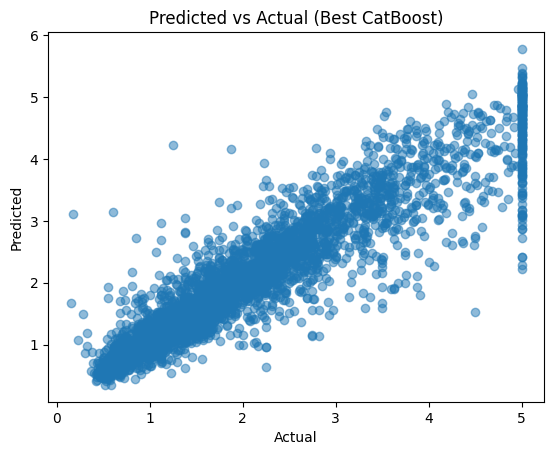

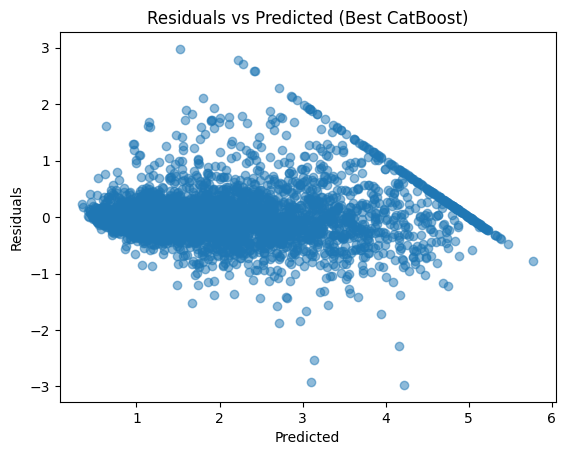

In [22]:
from catboost import CatBoostRegressor
import optuna

catboost_grid = {
    "depth": ("int", 4, 10),
    "learning_rate": ("float", 1e-3, 0.3, True),
    "l2_leaf_reg": ("float", 1e-2, 10.0, True),
    "iterations": ("int", 200, 1500, 100),
}

objective_cb = gen_objective(
    CatBoostRegressor,
    catboost_grid,
    X_train,
    y_train,
    cv=3,
    scorer="neg_root_mean_squared_error",
    fit_params={"verbose": False},
    random_state=42,
    n_jobs=-1,
    verbose=True
)

study_cb = optuna.create_study(direction="maximize")
study_cb.optimize(objective_cb, n_trials=30)

print("Best CatBoost params:", study_cb.best_params)
print("Best CV score (neg-RMSE):", study_cb.best_value)

best_cb = CatBoostRegressor(
    **study_cb.best_params,
    random_state=42,
    verbose=False
)
best_cb.fit(X_train, y_train)

pred_best_cb = best_cb.predict(X_test)

metrics(y_test, pred_best_cb)

pred_vs_actual_plot(
    y_test.values, pred_best_cb,
    title="Predicted vs Actual (Best CatBoost)"
)
residuals_vs_pred_plot(
    y_test.values, pred_best_cb,
    title="Residuals vs Predicted (Best CatBoost)"
)

# Лабораторная работа 2

Базовая версия Python: 3.14.0

In [5]:
# pip install -r requierments.txt

In [9]:
#!python -m venv venv
#./venv/Scripts/activate
#source venv/bin/activate

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

SEED = 42
np.random.seed(SEED)

In [49]:
df = pd.read_csv("portal_data.csv", encoding="utf-8", sep="|")
df.head()

,Вектор Мощи,Скорость перехода через портал,Приток Силы Потока,Ритм магического ядра,Поток Энергий,Сила Левого Потока,Сила Правого Потока,Пламя Стихий,Температура вдоха Истока,Температура выдоха Истока,Приток давления Выдоха Истока,Давление вдоха Истока,Давление выдоха Истока,Древний Ветер,Печать Чародея,Эмульсия Истока,Дыхание Истока,Гармония Бессмертия,Тип Вектора Мощи,Номер пометки
0,1.138,1.54332,289.964,141.318158,6677.380,7.584,7.584,464.006,736,-,1.096,Не определено,5.947,-,7.137,0.082,0.95,0.975,Слабый,0
1,2.088,-,6960.180,144.111767,6828.469,28.204,28.204,635.401,736,581.658,1.331,1.394603,7.282,1.019,10.655,0.287,0.95,0.975,Слабый,1
2,3.144,4.6299600000000005,8379.229,145.220853,7111.811,60.358,60.358,606.002,736,-,1.389,Не определено,7.574,-,13.086,0.259,0.95,0.975,Ниже среднего,2
3,4.161,6.17328,14724.395,162.050156,7792.630,113.774,113.774,661.471,736,-,1.658,Не определено,9.007,-,18.109,0.358,0.95,0.975,Ниже среднего,3
4,5.140,7.7166,21636.432,201.513586,8494.777,175.306,175.306,731.494,736,645.642,2.078,Не определено,11.197,1.026,26.373,0.522,0.95,0.975,Выше среднего,4


In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11934 entries, 0 to 11933
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Вектор Мощи                     11934 non-null  float64
 1   Скорость перехода через портал  11934 non-null  object 
 2   Приток Силы Потока              11934 non-null  float64
 3   Ритм магического ядра           11934 non-null  float64
 4   Поток Энергий                   11934 non-null  float64
 5   Сила Левого Потока              11934 non-null  float64
 6   Сила Правого Потока             11934 non-null  float64
 7   Пламя Стихий                    11934 non-null  float64
 8   Температура вдоха Истока        11934 non-null  int64  
 9   Температура выдоха Истока       11934 non-null  object 
 10  Приток давления Выдоха Истока   11934 non-null  float64
 11  Давление вдоха Истока           11934 non-null  object 
 12  Давление выдоха Истока          

In [51]:
df = df.replace({"-": np.nan, "Не определено": np.nan})

df.isna().sum()

Вектор Мощи                          0
Скорость перехода через портал    1203
Приток Силы Потока                   0
Ритм магического ядра                0
Поток Энергий                        0
Сила Левого Потока                   0
Сила Правого Потока                  0
Пламя Стихий                         0
Температура вдоха Истока             0
Температура выдоха Истока         9547
Приток давления Выдоха Истока        0
Давление вдоха Истока             9495
Давление выдоха Истока               0
Древний Ветер                     9547
Печать Чародея                       0
Эмульсия Истока                      0
Дыхание Истока                       0
Гармония Бессмертия                  0
Тип Вектора Мощи                     0
Номер пометки                        0
dtype: int64

In [52]:
df.head()

,Вектор Мощи,Скорость перехода через портал,Приток Силы Потока,Ритм магического ядра,Поток Энергий,Сила Левого Потока,Сила Правого Потока,Пламя Стихий,Температура вдоха Истока,Температура выдоха Истока,Приток давления Выдоха Истока,Давление вдоха Истока,Давление выдоха Истока,Древний Ветер,Печать Чародея,Эмульсия Истока,Дыхание Истока,Гармония Бессмертия,Тип Вектора Мощи,Номер пометки
0,1.138,1.54332,289.964,141.318158,6677.380,7.584,7.584,464.006,736,NaN,1.096,NaN,5.947,NaN,7.137,0.082,0.95,0.975,Слабый,0
1,2.088,NaN,6960.180,144.111767,6828.469,28.204,28.204,635.401,736,581.658,1.331,1.394603,7.282,1.019,10.655,0.287,0.95,0.975,Слабый,1
2,3.144,4.6299600000000005,8379.229,145.220853,7111.811,60.358,60.358,606.002,736,NaN,1.389,NaN,7.574,NaN,13.086,0.259,0.95,0.975,Ниже среднего,2
3,4.161,6.17328,14724.395,162.050156,7792.630,113.774,113.774,661.471,736,NaN,1.658,NaN,9.007,NaN,18.109,0.358,0.95,0.975,Ниже среднего,3
4,5.140,7.7166,21636.432,201.513586,8494.777,175.306,175.306,731.494,736,645.642,2.078,NaN,11.197,1.026,26.373,0.522,0.95,0.975,Выше среднего,4


In [53]:
drop_cols = [
    "Тип Вектора Мощи",
    "Номер пометки",
    "Температура выдоха Истока",
    "Давление вдоха Истока",
    "Древний Ветер",
]

df = df.drop(columns=drop_cols, errors="ignore")

In [54]:
df.head()

,Вектор Мощи,Скорость перехода через портал,Приток Силы Потока,Ритм магического ядра,Поток Энергий,Сила Левого Потока,Сила Правого Потока,Пламя Стихий,Температура вдоха Истока,Приток давления Выдоха Истока,Давление выдоха Истока,Печать Чародея,Эмульсия Истока,Дыхание Истока,Гармония Бессмертия
0,1.138,1.54332,289.964,141.318158,6677.380,7.584,7.584,464.006,736,1.096,5.947,7.137,0.082,0.95,0.975
1,2.088,NaN,6960.180,144.111767,6828.469,28.204,28.204,635.401,736,1.331,7.282,10.655,0.287,0.95,0.975
2,3.144,4.6299600000000005,8379.229,145.220853,7111.811,60.358,60.358,606.002,736,1.389,7.574,13.086,0.259,0.95,0.975
3,4.161,6.17328,14724.395,162.050156,7792.630,113.774,113.774,661.471,736,1.658,9.007,18.109,0.358,0.95,0.975
4,5.140,7.7166,21636.432,201.513586,8494.777,175.306,175.306,731.494,736,2.078,11.197,26.373,0.522,0.95,0.975


In [55]:
missing = df["Скорость перехода через портал"].isna().sum()
total = len(df)

missing, missing / total

(np.int64(1203), np.float64(0.1008044243338361))

In [56]:
df["Скорость перехода через портал"].describe()

count        10731
unique           9
top       12.34656
freq          1204
Name: Скорость перехода через портал, dtype: object

In [57]:
df["Скорость перехода через портал"] = pd.to_numeric(
    df["Скорость перехода через портал"],
    errors="coerce"
)

In [58]:
df.corr(numeric_only=True)[
    "Скорость перехода через портал"].sort_values(ascending=False)

Скорость перехода через портал    1.000000
Вектор Мощи                       0.999915
Поток Энергий                     0.986693
Давление выдоха Истока            0.967031
Приток давления Выдоха Истока     0.960650
Ритм магического ядра             0.960460
Пламя Стихий                      0.959044
Приток Силы Потока                0.958272
Сила Левого Потока                0.956388
Сила Правого Потока               0.956388
Эмульсия Истока                   0.927925
Печать Чародея                    0.909830
Дыхание Истока                    0.001264
Гармония Бессмертия              -0.005469
Температура вдоха Истока               NaN
Name: Скорость перехода через портал, dtype: float64

In [59]:
df["Скорость перехода через портал"].value_counts().sort_index()

Скорость перехода через портал
1.54332     1202
3.08664     1199
4.62996     1174
6.17328     1180
7.71660     1200
9.25992     1187
10.80324    1186
12.34656    1204
13.88988    1199
Name: count, dtype: int64

In [61]:
real_levels = df["Скорость перехода через портал"].dropna().unique()
real_levels = np.sort(real_levels)
real_levels

array([ 1.54332,  3.08664,  4.62996,  6.17328,  7.7166 ,  9.25992,
       10.80324, 12.34656, 13.88988])

In [62]:
from sklearn.ensemble import RandomForestRegressor

mask_missing = df["Скорость перехода через портал"].isna()
mask_not_missing = ~mask_missing

feature_cols = df.columns.drop("Скорость перехода через портал")

X_train = df.loc[mask_not_missing, feature_cols]
y_train = df.loc[mask_not_missing, "Скорость перехода через портал"]

model = RandomForestRegressor(
    n_estimators=300,
    random_state=42
)
model.fit(X_train, y_train)

,n_estimators,300
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [63]:
X_missing = df.loc[mask_missing, feature_cols]
predicted = model.predict(X_missing)

In [64]:
def nearest_level(x, levels):
    return levels[np.argmin(np.abs(levels - x))]


df.loc[mask_missing, "Скорость перехода через портал"] = [
    nearest_level(p, real_levels) for p in predicted
]

In [65]:
df["Скорость перехода через портал"].value_counts().sort_index()

Скорость перехода через портал
1.54332     1326
3.08664     1326
4.62996     1326
6.17328     1326
7.71660     1326
9.25992     1326
10.80324    1326
12.34656    1326
13.88988    1326
Name: count, dtype: int64

In [69]:
df.isna().sum()

Вектор Мощи                       0
Скорость перехода через портал    0
Приток Силы Потока                0
Ритм магического ядра             0
Поток Энергий                     0
Сила Левого Потока                0
Сила Правого Потока               0
Пламя Стихий                      0
Температура вдоха Истока          0
Приток давления Выдоха Истока     0
Давление выдоха Истока            0
Печать Чародея                    0
Эмульсия Истока                   0
Дыхание Истока                    0
Гармония Бессмертия               0
dtype: int64

In [24]:
X = df.drop(columns=["Гармония Бессмертия"])
y = df["Гармония Бессмертия"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED
)

len(X_train), len(X_test)

(9547, 2387)